In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import os
import time
import warnings
import gc
gc.collect()
import os
from six.moves import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn')
from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler

In [2]:
#Add All the Models Libraries
# preprocessing
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()
# Scalers
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

# Models

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error

from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
from scipy.stats import reciprocal, uniform

from sklearn.model_selection import StratifiedKFold, RepeatedKFold

# Cross-validation
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.model_selection import cross_validate

# GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Common data processors
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from scipy import sparse

In [3]:
# to make this notebook's output stable across runs
np.random.seed(123)
gc.collect()
# To plot pretty figures
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [4]:
#Reduce the memory usage - by Panchajanya Banerjee
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
train = reduce_mem_usage(pd.read_csv('train.csv',parse_dates=["first_active_month"]))
test = reduce_mem_usage(pd.read_csv('test.csv', parse_dates=["first_active_month"]))

Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to  2.24 Mb (52.5% reduction)


In [6]:
test.first_active_month = test.first_active_month.fillna(pd.to_datetime('2017-09-01'))
test.isnull().sum()

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64

In [7]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820312
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392822
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.687988
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142456
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159790


In [8]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04-01,C_ID_0ab67a22ab,3,3,1
1,2017-01-01,C_ID_130fd0cbdd,2,3,0
2,2017-08-01,C_ID_b709037bc5,5,1,1
3,2017-12-01,C_ID_d27d835a9f,2,1,0
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1


In [9]:
# Now extract the month, year, day, weekday
train["month"] = train["first_active_month"].dt.month
train["year"] = train["first_active_month"].dt.year
train['week'] = train["first_active_month"].dt.weekofyear
train['dayofweek'] = train['first_active_month'].dt.dayofweek
train['days'] = (datetime.date(2018, 2, 1) - train['first_active_month'].dt.date).dt.days
train['quarter'] = train['first_active_month'].dt.quarter

test["month"] = test["first_active_month"].dt.month
test["year"] = test["first_active_month"].dt.year
test['week'] = test["first_active_month"].dt.weekofyear
test['dayofweek'] = test['first_active_month'].dt.dayofweek
test['days'] = (datetime.date(2018, 2, 1) - test['first_active_month'].dt.date).dt.days
test['quarter'] = test['first_active_month'].dt.quarter

In [10]:
# Taking Reference from Other Kernels
def aggregate_transaction_hist(trans, prefix):  
        
    agg_func = {
        'purchase_date' : ['max','min'],
        'month_diff' : ['mean', 'min', 'max', 'var'],
        'month_diff_lag' : ['mean', 'min', 'max', 'var'],
        'weekend' : ['sum', 'mean'],
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['sum','mean', 'max','min'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],  
        'month_lag': ['max','min','mean','var'],
        'card_id' : ['size'],
        'month': ['nunique'],
        'hour': ['nunique'],
        'weekofyear': ['nunique'],
        'dayofweek': ['nunique'],
        'year': ['nunique'],
        'subsector_id': ['nunique'],
        'merchant_category_id' : ['nunique'],
        'merchant_id' : ['nunique', lambda x:stats.mode(x)[0]],
        'state_id' : ['nunique', lambda x:stats.mode(x)[0]],
    }
    
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)
    
    df = (trans.groupby('card_id').size().reset_index(name='{}transactions_count'.format(prefix)))
    
    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')
    
    return agg_trans

In [11]:
transactions = reduce_mem_usage(pd.read_csv('historical_transactions_clean_outlier.csv'))
transactions = transactions.loc[transactions.purchase_amount < 50,]
transactions['authorized_flag'] = transactions['authorized_flag'].map({'Y': 1, 'N': 0})
transactions['category_1'] = transactions['category_1'].map({'Y': 0, 'N': 1})

Mem. usage decreased to 1638.06 Mb (50.8% reduction)


In [12]:
transactions.head()

,Unnamed: 0,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,0,1,C_ID_4e6213e9bc,88,1,0,0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,1,1,C_ID_4e6213e9bc,88,1,0,0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,2,1,C_ID_4e6213e9bc,88,1,0,0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,3,1,C_ID_4e6213e9bc,88,1,0,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,4,1,C_ID_4e6213e9bc,88,1,0,0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [13]:
#Feature Engineering - Adding new features 
transactions['purchase_date'] = pd.to_datetime(transactions['purchase_date'])
transactions['year'] = transactions['purchase_date'].dt.year
transactions['weekofyear'] = transactions['purchase_date'].dt.weekofyear
transactions['month'] = transactions['purchase_date'].dt.month
transactions['dayofweek'] = transactions['purchase_date'].dt.dayofweek
transactions['weekend'] = (transactions.purchase_date.dt.weekday >=5).astype(int)
transactions['hour'] = transactions['purchase_date'].dt.hour 
transactions['quarter'] = transactions['purchase_date'].dt.quarter
transactions['month_diff'] = ((pd.to_datetime('01/03/2018') - transactions['purchase_date']).dt.days)//30
transactions['month_diff_lag'] = transactions['month_diff'] + transactions['month_lag']

gc.collect()

143

In [14]:
# agg_func = {'mean': ['mean'],}
# for col in ['category_2','category_3']:
#     transactions[col+'_mean'] = transactions['purchase_amount'].groupby(transactions[col]).agg('mean')
#     transactions[col+'_max'] = transactions['purchase_amount'].groupby(transactions[col]).agg('max')
#     transactions[col+'_min'] = transactions['purchase_amount'].groupby(transactions[col]).agg('min')
#     transactions[col+'_var'] = transactions['purchase_amount'].groupby(transactions[col]).agg('var')
#     agg_func[col+'_mean'] = ['mean']
# gc.collect()

In [15]:
merchants = reduce_mem_usage(pd.read_csv('merchants_clean.csv'))
merchants = merchants.drop(['Unnamed: 0', 'merchant_group_id', 'merchant_category_id',
                            'subsector_id', 'numerical_1', 'numerical_2', 
                            'active_months_lag3','active_months_lag6',
                            'city_id', 'state_id'
                           ], axis = 1)
d = dict(zip(merchants.columns[1:], ['histchant_{}'.format(x) for x in (merchants.columns[1:])]))
d.update({"merchant_id": "hist_merchant_id_<lambda>"})
merchants = merchants.rename(index=str, columns= d)
## convert the month in business to categorical
merchants.histchant_active_months_lag12 = pd.cut(merchants.histchant_active_months_lag12, 4)

Mem. usage decreased to 16.91 Mb (71.2% reduction)


In [16]:
merge_trans = aggregate_transaction_hist(transactions, prefix='hist_')
merge_trans = merge_trans.merge(merchants, on = 'hist_merchant_id_<lambda>', how = 'left')
## hist transaction frequency
merge_trans['hist_freq'] = merge_trans.hist_transactions_count/(((merge_trans.hist_purchase_date_max - 
                                                         merge_trans.hist_purchase_date_min).dt.total_seconds())/86400)
merge_trans['hist_freq_amount'] = merge_trans['hist_freq'] * merge_trans['hist_purchase_amount_mean']
merge_trans['hist_freq_install'] = merge_trans['hist_freq'] * merge_trans['hist_installments_mean']

In [17]:
cols = ['histchant_avg_sales_lag3','histchant_avg_purchases_lag3',
        'histchant_avg_sales_lag6','histchant_avg_purchases_lag6',
        'histchant_avg_sales_lag12','histchant_avg_purchases_lag12','hist_freq']
for col in cols:
    merge_trans[col] = pd.qcut(merge_trans[col], 4)

In [18]:
for col in cols:
    merge_trans[col].fillna(merge_trans[col].mode()[0], inplace=True)
    label_enc.fit(list(merge_trans[col].values)) 
    merge_trans[col] = label_enc.transform(list(merge_trans[col].values))

In [19]:
for col in ['histchant_category_1','histchant_most_recent_sales_range','histchant_most_recent_purchases_range',
           'histchant_active_months_lag12','histchant_category_4','histchant_category_2']:
    merge_trans[col].fillna(merge_trans[col].mode()[0], inplace=True)

In [20]:
label_enc.fit(list(merge_trans['hist_merchant_id_<lambda>'].values)) 
merge_trans['hist_merchant_id_<lambda>'] = label_enc.transform(list(merge_trans['hist_merchant_id_<lambda>'].values))
label_enc.fit(list(merge_trans['histchant_active_months_lag12'].values)) 
merge_trans['histchant_active_months_lag12'] = label_enc.transform(list(merge_trans['histchant_active_months_lag12'].values))

In [21]:
#del transactions
gc.collect()
train = pd.merge(train, merge_trans, on='card_id',how='left')
test = pd.merge(test, merge_trans, on='card_id',how='left')
#del merge_trans
gc.collect()

14

In [22]:
#Feature Engineering - Adding new features 
train['hist_purchase_date_max'] = pd.to_datetime(train['hist_purchase_date_max'])
train['hist_purchase_date_min'] = pd.to_datetime(train['hist_purchase_date_min'])
train['hist_purchase_date_diff'] = (train['hist_purchase_date_max'] - train['hist_purchase_date_min']).dt.days
train['hist_purchase_date_average'] = train['hist_purchase_date_diff']/train['hist_card_id_size']
train['hist_purchase_date_uptonow'] = (pd.to_datetime('01/03/2018') - train['hist_purchase_date_max']).dt.days
train['hist_purchase_date_uptomin'] = (pd.to_datetime('01/03/2018') - train['hist_purchase_date_min']).dt.days
train['hist_first_buy'] = (train['hist_purchase_date_min'] - train['first_active_month']).dt.days
for feature in ['hist_purchase_date_max','hist_purchase_date_min']:
    train[feature] = train[feature].astype(np.int64) * 1e-9
gc.collect()

75

In [23]:
#Feature Engineering - Adding new features 
test['hist_purchase_date_max'] = pd.to_datetime(test['hist_purchase_date_max'])
test['hist_purchase_date_min'] = pd.to_datetime(test['hist_purchase_date_min'])
test['hist_purchase_date_diff'] = (test['hist_purchase_date_max'] - test['hist_purchase_date_min']).dt.days
test['hist_purchase_date_average'] = test['hist_purchase_date_diff']/test['hist_card_id_size']
test['hist_purchase_date_uptonow'] = (pd.to_datetime('01/03/2018') - test['hist_purchase_date_max']).dt.days
test['hist_purchase_date_uptomin'] = (pd.to_datetime('01/03/2018') - test['hist_purchase_date_min']).dt.days

test['hist_first_buy'] = (test['hist_purchase_date_min'] - test['first_active_month']).dt.days
for feature in ['hist_purchase_date_max','hist_purchase_date_min']:
    test[feature] = test[feature].astype(np.int64) * 1e-9

gc.collect()

95

In [24]:
# Taking Reference from Other Kernels
def aggregate_transaction_new(trans, prefix):  
        
    agg_func = {
        'purchase_date' : ['max','min'],
        'month_diff' : ['mean', 'min', 'max'],
        'month_diff_lag' : ['mean', 'min', 'max'],
        'weekend' : ['sum', 'mean'],
        'authorized_flag': ['sum'],
        'category_1': ['sum','mean', 'max','min'],
        'purchase_amount': ['sum', 'mean', 'max', 'min'],
        'installments': ['sum', 'mean', 'max', 'min'],  
        'month_lag': ['max','min','mean'],
        'card_id' : ['size'],
        'month': ['nunique'],
        'hour': ['nunique'],
        'weekofyear': ['nunique'],
        'dayofweek': ['nunique'],
        'year': ['nunique'],
        'subsector_id': ['nunique'],
        'merchant_category_id' : ['nunique'],
        'merchant_id' : ['nunique', lambda x:stats.mode(x)[0]],
        'state_id' : ['nunique', lambda x:stats.mode(x)[0]],
    }
    
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)
    
    df = (trans.groupby('card_id').size().reset_index(name='{}transactions_count'.format(prefix)))
    
    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')
    
    return agg_trans

In [25]:
# Now extract the data from the new transactions
new_transactions = reduce_mem_usage(pd.read_csv('new_merchant_transactions_clean_outlier.csv'))
new_transactions = new_transactions.loc[new_transactions.purchase_amount < 50,]
new_transactions['authorized_flag'] = new_transactions['authorized_flag'].map({'Y': 1, 'N': 0})
new_transactions['category_1'] = new_transactions['category_1'].map({'Y': 0, 'N': 1})

Mem. usage decreased to 106.71 Mb (52.5% reduction)


In [26]:
#Feature Engineering - Adding new features inspired by Chau's first kernel
new_transactions['purchase_date'] = pd.to_datetime(new_transactions['purchase_date'])
new_transactions['year'] = new_transactions['purchase_date'].dt.year
new_transactions['weekofyear'] = new_transactions['purchase_date'].dt.weekofyear
new_transactions['month'] = new_transactions['purchase_date'].dt.month
new_transactions['dayofweek'] = new_transactions['purchase_date'].dt.dayofweek
new_transactions['weekend'] = (new_transactions.purchase_date.dt.weekday >=5).astype(int)
new_transactions['hour'] = new_transactions['purchase_date'].dt.hour 
new_transactions['quarter'] = new_transactions['purchase_date'].dt.quarter
new_transactions['is_month_start'] = new_transactions['purchase_date'].dt.is_month_start
new_transactions['month_diff'] = ((pd.to_datetime('01/03/2018') - new_transactions['purchase_date']).dt.days)//30
new_transactions['month_diff_lag'] = new_transactions['month_diff'] + new_transactions['month_lag']

gc.collect()

# new_transactions['Christmas_Day_2017'] = (pd.to_datetime('2017-12-25') - 
#                                           new_transactions['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x <= 15 else 0)
# new_transactions['Valentine_Day_2017'] = (pd.to_datetime('2017-06-13') - 
#                                           new_transactions['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x <= 7 else 0)
# #Black Friday : 24th November 2017
# new_transactions['Black_Friday_2017'] = (pd.to_datetime('2017-11-27') - 
#                                          new_transactions['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x <= 7 else 0)

# aggs = {'mean': ['mean'],}

# for col in ['category_2','category_3']:
#     new_transactions[col+'_mean'] = new_transactions['purchase_amount'].groupby(new_transactions[col]).agg('mean')
#     new_transactions[col+'_max'] = new_transactions['purchase_amount'].groupby(new_transactions[col]).agg('max')
#     new_transactions[col+'_min'] = new_transactions['purchase_amount'].groupby(new_transactions[col]).agg('min')
#     new_transactions[col+'_var'] = new_transactions['purchase_amount'].groupby(new_transactions[col]).agg('var')
#     aggs[col+'_mean'] = ['mean']
gc.collect()

0

In [27]:
merchants = reduce_mem_usage(pd.read_csv('merchants_clean.csv'))
merchants = merchants.drop(['Unnamed: 0', 'merchant_group_id', 'merchant_category_id',
                            'subsector_id', 'numerical_1', 'numerical_2', 
                            'active_months_lag3','active_months_lag6',
                            'city_id', 'state_id',
                           ], axis = 1)
d = dict(zip(merchants.columns[1:], ['newchant_{}'.format(x) for x in (merchants.columns[1:])]))
d.update({"merchant_id": "new_merchant_id_<lambda>"})
merchants = merchants.rename(index=str, columns= d)
## convert the month in business to categorical
merchants.newchant_active_months_lag12 = pd.cut(merchants.newchant_active_months_lag12, 4)

Mem. usage decreased to 16.91 Mb (71.2% reduction)


In [28]:
merge_new = aggregate_transaction_new(new_transactions, prefix='new_')
merge_new = merge_new.merge(merchants, on = 'new_merchant_id_<lambda>', how = 'left')
## new transaction frequency
merge_new['new_freq'] = merge_new.new_transactions_count/(((merge_new.new_purchase_date_max - 
                                                         merge_new.new_purchase_date_min).dt.total_seconds())/86400)
merge_new['new_freq_amount'] = merge_new['new_freq'] * merge_new['new_purchase_amount_mean']
merge_new['new_freq_install'] = merge_new['new_freq'] * merge_new['new_installments_mean']

In [29]:
cols = ['newchant_avg_sales_lag3','newchant_avg_purchases_lag3',
        'newchant_avg_sales_lag6','newchant_avg_purchases_lag6',
        'newchant_avg_sales_lag12','newchant_avg_purchases_lag12','new_freq']
for col in cols:
    merge_new[col] = pd.qcut(merge_new[col], 4)

In [30]:
for col in cols:
    merge_new[col].fillna(merge_new[col].mode()[0], inplace=True)
    label_enc.fit(list(merge_new[col].values)) 
    merge_new[col] = label_enc.transform(list(merge_new[col].values))

In [31]:
for col in ['newchant_category_1','newchant_most_recent_sales_range','newchant_most_recent_purchases_range',
           'newchant_active_months_lag12','newchant_category_4','newchant_category_2']:
    merge_new[col].fillna(merge_new[col].mode()[0], inplace=True)

In [32]:
label_enc.fit(list(merge_new['new_merchant_id_<lambda>'].values)) 
merge_new['new_merchant_id_<lambda>'] = label_enc.transform(list(merge_new['new_merchant_id_<lambda>'].values))
label_enc.fit(list(merge_new['newchant_active_months_lag12'].values)) 
merge_new['newchant_active_months_lag12'] = label_enc.transform(list(merge_new['newchant_active_months_lag12'].values))

In [33]:
#del new_transactions
gc.collect()

train = pd.merge(train, merge_new, on='card_id',how='left')
test = pd.merge(test, merge_new, on='card_id',how='left')
#del merge_new

gc.collect()

28

In [34]:
train_na = train.isnull().sum()
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Value' :train_na})
missing_data.head(5)

,Missing Value
new_freq_install,35115
new_category_1_mean,21931
new_month_lag_max,21931
new_installments_min,21931
new_installments_max,21931


In [35]:
for col in ['new_freq','new_purchase_amount_min','new_purchase_amount_max','newchant_category_4','new_weekend_mean',''
           'new_purchase_amount_mean','newchant_active_months_lag12','new_weekend_sum','newchant_avg_purchases_lag12',
           'newchant_avg_sales_lag12','newchant_avg_purchases_lag6','newchant_avg_sales_lag6','new_category_1_sum',
            'newchant_avg_purchases_lag3','newchant_avg_sales_lag3','new_category_1_mean','new_category_1_max',
           'new_category_1_min','newchant_most_recent_purchases_range','newchant_most_recent_sales_range',
            'newchant_category_1'] :     # -1
    train[col] = train[col].fillna(-1.0)
    
for col in ['new_installments_min','new_installments_max','new_installments_mean','new_installments_sum',
            'new_purchase_amount_sum','new_state_id_<lambda>' ]:      # -2
    train[col] = train[col].fillna(-2.0)  
    
for col in ['newchant_category_2','new_authorized_flag_sum','new_month_lag_min','new_month_lag_max','new_card_id_size',
           'new_month_lag_mean','new_weekofyear_nunique','new_year_nunique','new_state_id_nunique',
            'new_merchant_id_<lambda>','new_merchant_id_nunique','new_merchant_category_id_nunique',
            'new_subsector_id_nunique','new_dayofweek_nunique','new_hour_nunique','new_month_nunique',
            'new_transactions_count']:      # 0
    train[col] = train[col].fillna(0.0)
    
train.new_month_diff_mean = train.new_month_diff_mean.fillna(23)
train.new_month_diff_min = train.new_month_diff_min.fillna(23)
train.new_month_diff_max = train.new_month_diff_max.fillna(24)
train.new_month_diff_lag_mean = train.new_month_diff_lag_mean.fillna(24)
train.new_month_diff_lag_min = train.new_month_diff_lag_min.fillna(24)
train.new_month_diff_lag_max = train.new_month_diff_lag_max.fillna(24)

In [36]:
for col in ['new_freq','new_purchase_amount_min','new_purchase_amount_max','newchant_category_4','new_weekend_mean',''
           'new_purchase_amount_mean','newchant_active_months_lag12','new_weekend_sum','newchant_avg_purchases_lag12',
           'newchant_avg_sales_lag12','newchant_avg_purchases_lag6','newchant_avg_sales_lag6','new_category_1_sum',
            'newchant_avg_purchases_lag3','newchant_avg_sales_lag3','new_category_1_mean','new_category_1_max',
           'new_category_1_min','newchant_most_recent_purchases_range','newchant_most_recent_sales_range',
            'newchant_category_1'] :     # -1
    test[col] = test[col].fillna(-1.0)
    
for col in ['new_installments_min','new_installments_max','new_installments_mean','new_installments_sum',
            'new_purchase_amount_sum','new_state_id_<lambda>' ]:      # -2
    test[col] = test[col].fillna(-2.0)  
    
for col in ['newchant_category_2','new_authorized_flag_sum','new_month_lag_min','new_month_lag_max','new_card_id_size',
           'new_month_lag_mean','new_weekofyear_nunique','new_year_nunique','new_state_id_nunique',
            'new_merchant_id_<lambda>','new_merchant_id_nunique','new_merchant_category_id_nunique',
            'new_subsector_id_nunique','new_dayofweek_nunique','new_hour_nunique','new_month_nunique',
            'new_transactions_count']:      # 0
    test[col] = test[col].fillna(0.0)
    
test.new_month_diff_mean = test.new_month_diff_mean.fillna(23)
test.new_month_diff_min = test.new_month_diff_min.fillna(23)
test.new_month_diff_max = test.new_month_diff_max.fillna(24)
test.new_month_diff_lag_mean = test.new_month_diff_lag_mean.fillna(24)
test.new_month_diff_lag_min = test.new_month_diff_lag_min.fillna(24)
test.new_month_diff_lag_max = test.new_month_diff_lag_max.fillna(24)

In [37]:
for col in ['new_purchase_date_min','new_purchase_date_max']:
    train[col] = train[col].fillna(pd.to_datetime(1/9/2017))
    test[col] = test[col].fillna(pd.to_datetime(1/9/2017))

In [38]:
#Feature Engineering - Adding new features inspired by Chau's first kernel
train['new_purchase_date_max'] = pd.to_datetime(train['new_purchase_date_max'])
train['new_purchase_date_min'] = pd.to_datetime(train['new_purchase_date_min'])
train['new_purchase_date_diff'] = (train['new_purchase_date_max'] - train['new_purchase_date_min']).dt.days
train['new_purchase_date_average'] = train['new_purchase_date_diff']/train['new_card_id_size']
train['new_purchase_date_uptonow'] = (pd.to_datetime('01/03/2018') - train['new_purchase_date_max']).dt.days
train['new_purchase_date_uptomin'] = (pd.to_datetime('01/03/2018') - train['new_purchase_date_min']).dt.days
train['new_first_buy'] = (train['new_purchase_date_min'] - train['first_active_month']).dt.days
for feature in ['new_purchase_date_max','new_purchase_date_min']:
    train[feature] = train[feature].astype(np.int64) * 1e-9

#Feature Engineering - Adding new features inspired by Chau's first kernel
test['new_purchase_date_max'] = pd.to_datetime(test['new_purchase_date_max'])
test['new_purchase_date_min'] = pd.to_datetime(test['new_purchase_date_min'])
test['new_purchase_date_diff'] = (test['new_purchase_date_max'] - test['new_purchase_date_min']).dt.days
test['new_purchase_date_average'] = test['new_purchase_date_diff']/test['new_card_id_size']
test['new_purchase_date_uptonow'] = (pd.to_datetime('01/03/2018') - test['new_purchase_date_max']).dt.days
test['new_purchase_date_uptomin'] = (pd.to_datetime('01/03/2018') - test['new_purchase_date_min']).dt.days
test['new_first_buy'] = (test['new_purchase_date_min'] - test['first_active_month']).dt.days
for feature in ['new_purchase_date_max','new_purchase_date_min']:
    test[feature] = test[feature].astype(np.int64) * 1e-9
    
#added new feature - Interactive
train['card_id_total'] = train['new_card_id_size'] + train['hist_card_id_size']
train['purchase_amount_total'] = train['new_purchase_amount_sum'] + train['hist_purchase_amount_sum']

test['card_id_total'] = test['new_card_id_size'] + test['hist_card_id_size']
test['purchase_amount_total'] = test['new_purchase_amount_sum'] + test['hist_purchase_amount_sum']

gc.collect()

100

In [39]:
train.new_purchase_date_average = train.new_purchase_date_average.fillna(-1.0)
test.new_purchase_date_average = test.new_purchase_date_average.fillna(-1.0)

In [40]:
train = train.drop(['hist_card_id_size','new_card_id_size'], axis = 1)
test = test.drop(['hist_card_id_size','new_card_id_size'], axis = 1)

In [41]:
train.shape

(201917, 136)

In [42]:
train.new_freq_amount.value_counts()
cols = ['new_freq_amount',]
for col in cols:
    train[col] = train[col].fillna(0)
    train[col] = pd.qcut(train[col], 5)
    label_enc.fit(list(train[col].values)) 
    train[col] = label_enc.transform(list(train[col].values))
    
    test[col] = test[col].fillna(0)
    test[col] = pd.qcut(test[col], 5)
    label_enc.fit(list(test[col].values)) 
    test[col] = label_enc.transform(list(test[col].values))

train = train.drop(['new_freq_install'], axis = 1) 
test = test.drop(['new_freq_install'], axis = 1)  

In [43]:
train = train.drop(['card_id', 'first_active_month'], axis = 1)
test = test.drop(['card_id', 'first_active_month'], axis = 1)

In [44]:
# Remove the Outliers if any 
train['outliers'] = 0
train.loc[train['target'] < -30, 'outliers'] = 1
train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [45]:
for features in ['feature_1','feature_2','feature_3']:
    order_label = train.groupby([features])['outliers'].mean()
    train[features] = train[features].map(order_label)
    test[features] =  test[features].map(order_label)

In [46]:
# Get the X and Y
df_train_columns = [c for c in train.columns if c not in ['target','outliers']] 
cat_features = [c for c in df_train_columns if 'feature_' in c] 
#df_train_columns

In [47]:
target = train['target']
del train['target']

In [48]:
import lightgbm as lgb

param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train,train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1251]	training's rmse: 3.32102	valid_1's rmse: 3.65137
fold 1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1096]	training's rmse: 3.34254	valid_1's rmse: 3.65416
fold 2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1876]	training's rmse: 3.22936	valid_1's rmse: 3.6534
fold 3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1431]	training's rmse: 3.2868	valid_1's rmse: 3.65047
fold 4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1407]	training's rmse: 3.28746	valid_1's rmse: 3.64699


3.6512778705892

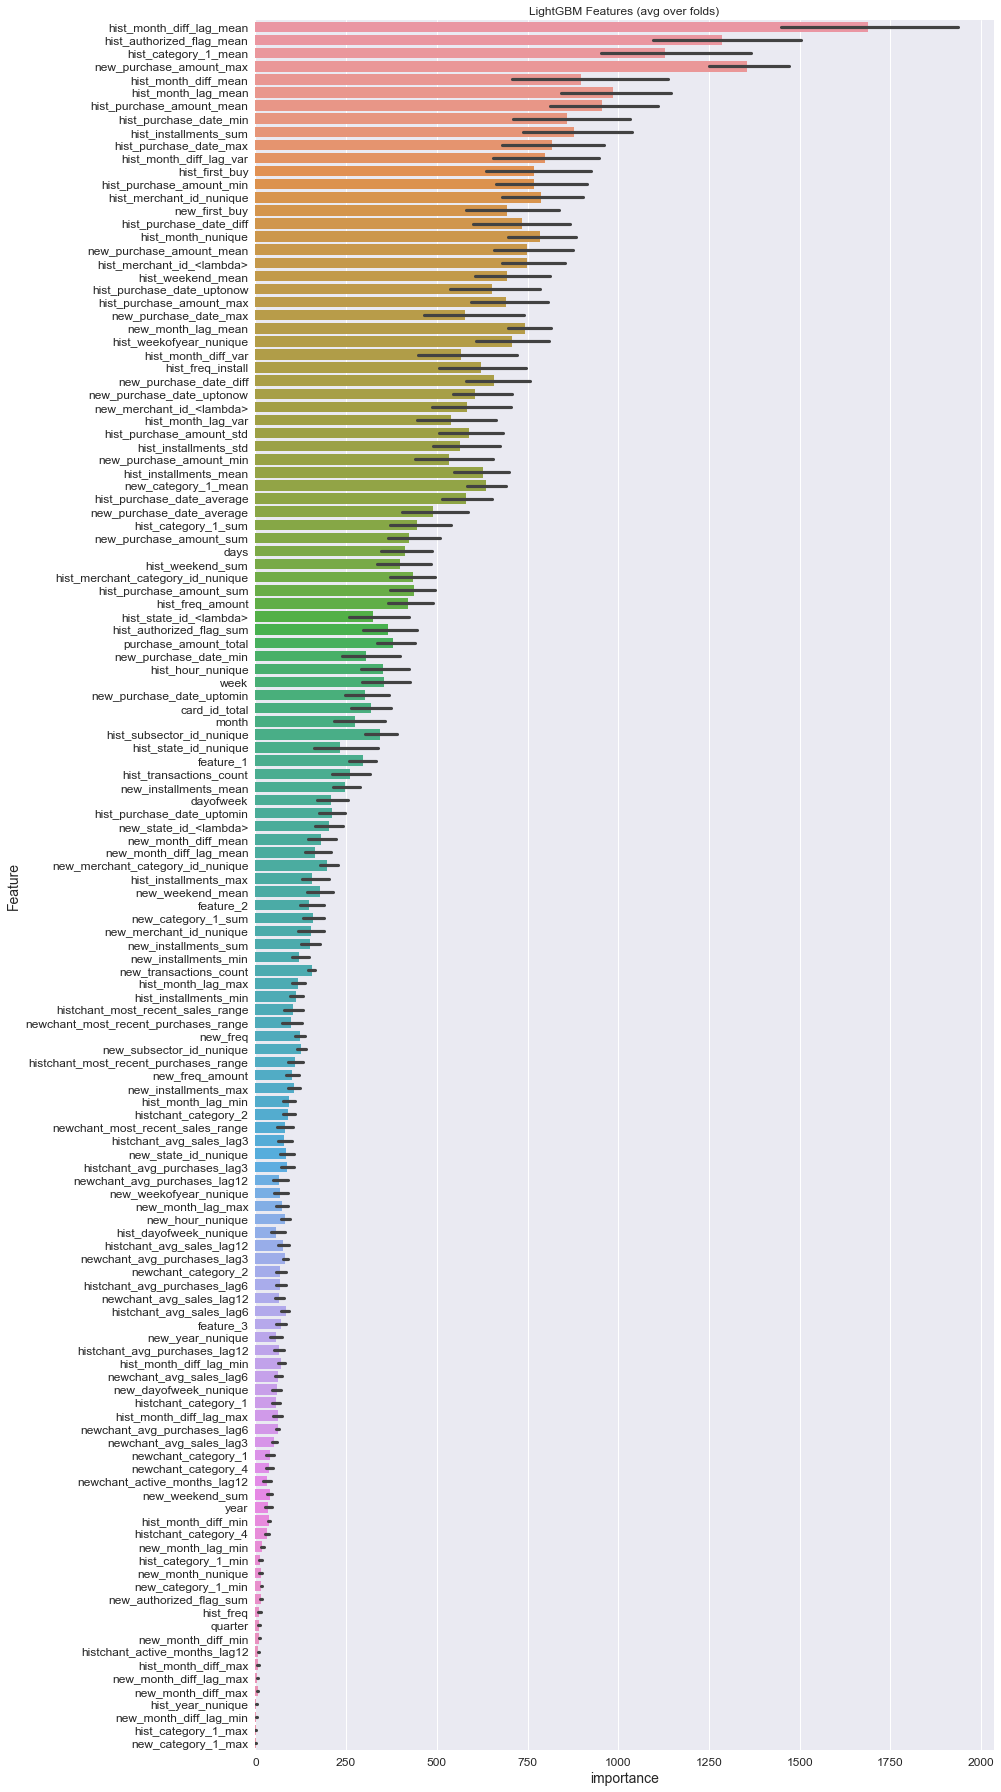

In [49]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [50]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
cat_features = [c for c in features if 'feature_' in c]

In [51]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}

folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4590)
oof_2 = np.zeros(len(train))
predictions_2 = np.zeros(len(test))
feature_importance_df_2 = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=cat_features)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=cat_features)

    num_round = 10000
    clf_r = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 200)
    oof_2[val_idx] = clf_r.predict(train.iloc[val_idx][features], num_iteration=clf_r.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf_r.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df_2 = pd.concat([feature_importance_df_2, fold_importance_df], axis=0)
    
    predictions_2 += clf_r.predict(test[features], num_iteration=clf_r.best_iteration) / (5 * 2)

print("CV score: {:<8.5f}".format(mean_squared_error(oof_2, target)**0.5))

fold 0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1241]	training's rmse: 3.30163	valid_1's rmse: 3.72638
fold 1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1102]	training's rmse: 3.35026	valid_1's rmse: 3.61529
fold 2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1020]	training's rmse: 3.35761	valid_1's rmse: 3.63647
fold 3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1249]	training's rmse: 3.31495	valid_1's rmse: 3.66862
fold 4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1688]	training's rmse: 3.26032	valid_1's rmse: 3.64421
fold 5
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1040]	training's rmse: 3.33338	valid_1's rmse: 3.74135
fold 6
Training until validation s

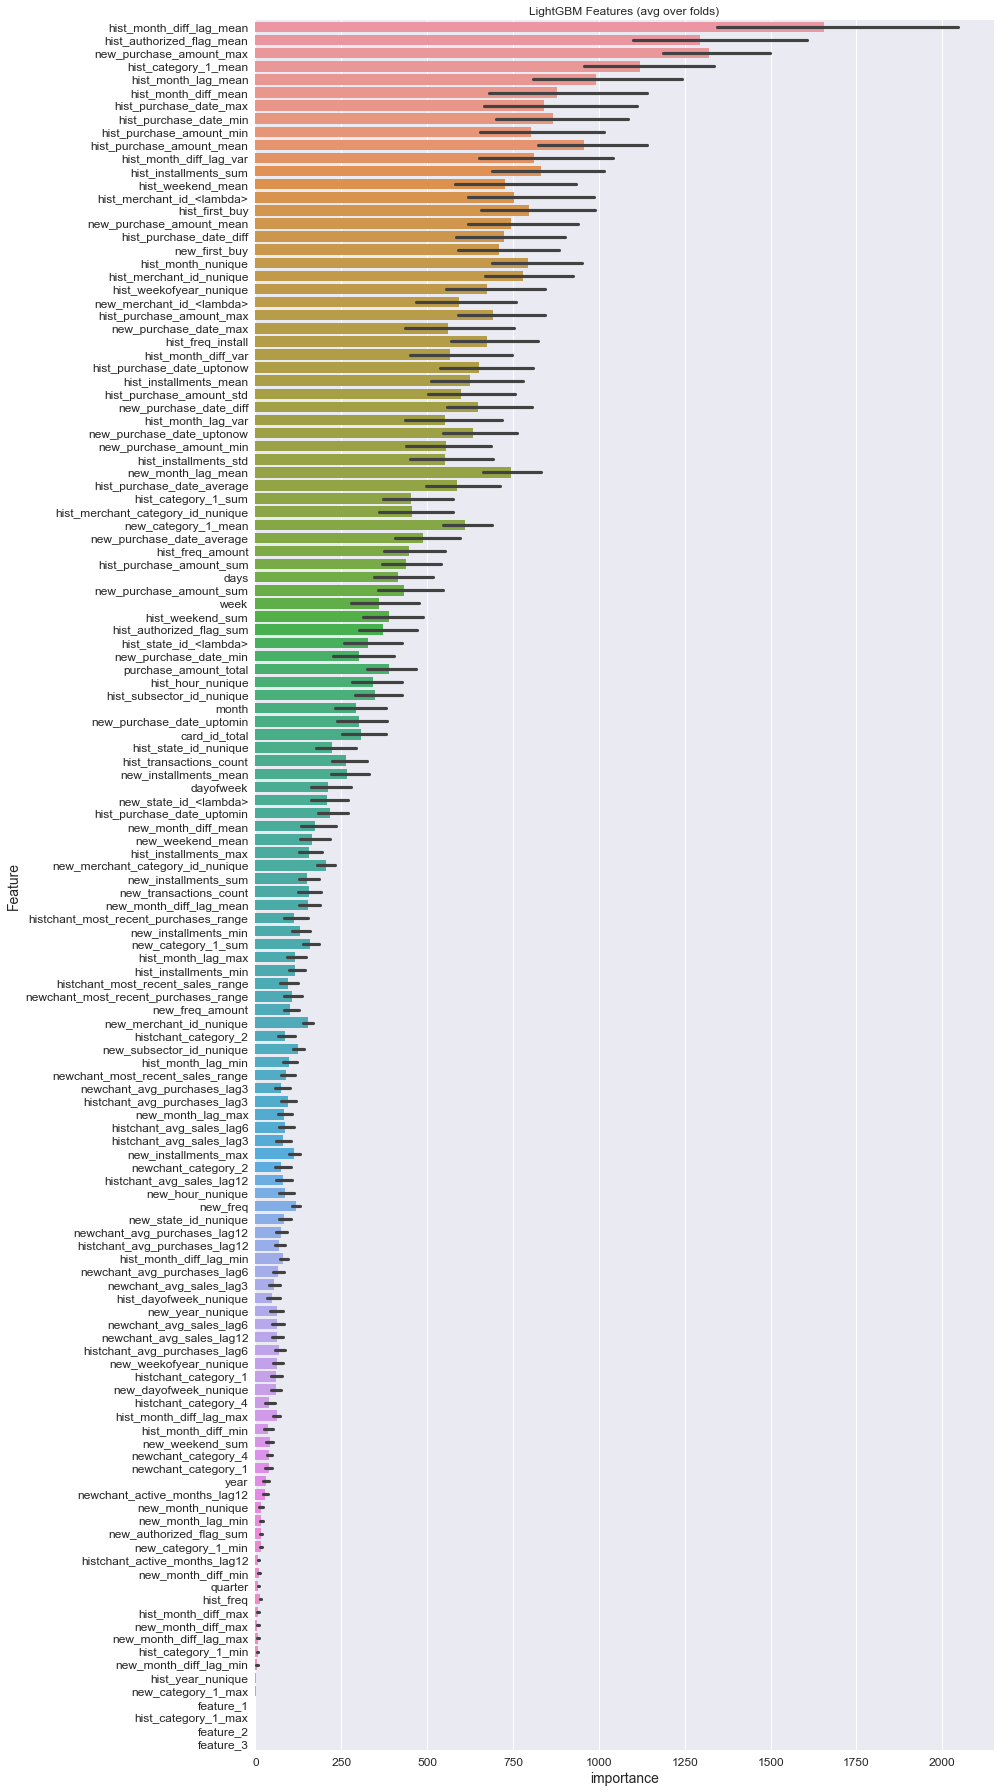

In [52]:
cols = (feature_importance_df_2[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df_2.loc[feature_importance_df_2.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [53]:
from sklearn.linear_model import BayesianRidge

train_stack = np.vstack([oof,oof_2]).transpose()
test_stack = np.vstack([predictions, predictions_2]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=1, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions_3 = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions_3 += clf_3.predict(test_stack) / 5
    
np.sqrt(mean_squared_error(target.values, oof_stack))

fold 0
fold 1
fold 2
fold 3
fold 4


3.6483669989654546

In [112]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['target'] = predictions_3
#sample_submission.loc[sample_submission.target < -19, 'target'] = -33.218750
sample_submission.to_csv('submission.csv', index=False)

In [110]:
((sample_submission.target <= -13) & (sample_submission.target > -18)).sum()

154

In [111]:
((target > -30) & (target < -13)).sum()

23

In [113]:
combine = pd.read_csv('combining_submission.csv')
sample_submission['target'] = predictions_3*0.7 + combine['target']*0.3
q = sample_submission['target'].quantile(0.002)
sample_submission['target'] = sample_submission['target'].apply(lambda x: x if x > q else x*1.1)
sample_submission.loc[sample_submission.target < -18, 'target'] = -33.218750
sample_submission.to_csv('submission.csv', index=False)